In [6]:
import os 
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

# Import package
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from src.exchange import TOB_Exchange

%load_ext autoreload 
%autoreload 2

## Import Data

In [7]:
folder_path = 'data_loader/datasets/'

In [8]:
def get_data(files_list):
    df = pd.DataFrame()
    # Use a loop to get all the csv.gz files from the path location in a single Dataframe
    for csv_file in tqdm(files_list):
        file_name = (folder_path + csv_file)
        if file_name[-2:] == "gz":
            df1 = pd.read_csv(file_name, compression='gzip')
            # Concatenate all the dataframes into a single dataframe
            df = pd.concat([df, df1], ignore_index=True)
    return df

In [9]:
# define folder path
files_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'binance' 
    and f.split('_')[-1] == 'COMPBTC.csv.gz'
    and f.split('_')[1] == 'quotes']
files_list

['binance_quotes_2023-07-01_COMPBTC.csv.gz']

In [10]:
binance_data = get_data(files_list)

100%|██████████| 1/1 [00:00<00:00, 29.08it/s]


In [11]:
binance_data['time'] = pd.to_datetime(binance_data.timestamp, unit='us')
binance_data.set_index('time', inplace=True)

## Open Exchange

In [12]:
# Create new exchange called binance with a average latency of 5000 us and 29% std
binance = TOB_Exchange(latency=[5000, 0.29])
# Were traing one market in this example, so were adding it to the markets
symbol = 'COMPBTC'
binance.add_market(symbol, 'COMP', 'BTC')
# We start with a balance for only BTC 
binance.add_balance('COMP', 0)
binance.add_balance('BTC', 0.1)

# Now we can load the TOB data into the exchange events
lst = binance_data[['timestamp', 'bid_amount', 'bid_price', 'ask_price', 'ask_amount']].sort_values('timestamp').to_numpy()
binance.load_tob(lst, symbol)

## Strategy

In [13]:
# Our signal is a simple top-of-book pressure. 
# If the TOB is dominated by buys (99.9% of the TOB quanitites are buys) then we enter a market buy order
# If the TOB is dominated by sells (0.1% of the TOB quanitites are buys) then we enter a market sell order

def signal(tob):
    bid_pressure = tob['bid_quantity'] / (tob['bid_quantity'] + tob['ask_quantity'])

    if bid_pressure >= 0.999: 
        return 1 
    
    elif bid_pressure <= 0.001: 
        return -1 
    
    else: 
        return 0

In [14]:
# We can now embed this signal into a simple strategy class that runs on every update

class tob_imbalance(): 
    def __init__(self):
        self.symbol = 'COMPBTC'
        self.amount = 4

        self.flag = False

    def run_strategy(self):

        tob = binance.fetch_tob(self.symbol)

        decision = signal(tob)

        if (decision == 1) and not (self.flag): 
            binance.market_order(symbol, self.amount, 1, tob['timestamp'])
            self.flag = True

        elif (decision == -1) and (self.flag): 
            binance.market_order(symbol, self.amount, 0, tob['timestamp'])
            self.flag = False

        else: 
            pass

In [15]:
binance.run_simulation(tob_imbalance)

Trade Executed Trade(symbol='COMPBTC', trade_id=0, order_id=0, side=1, taker=True, amount=4, price=0.001804, entryTime=1688171402534425.2, eventTime=1688171402534425.2)
Trade Executed Trade(symbol='COMPBTC', trade_id=1, order_id=1, side=0, taker=True, amount=4, price=0.001803, entryTime=1688173204436503.5, eventTime=1688173204436503.5)
Trade Executed Trade(symbol='COMPBTC', trade_id=2, order_id=2, side=1, taker=True, amount=4, price=0.001792, entryTime=1688179345403261.0, eventTime=1688179345403261.0)
Trade Executed Trade(symbol='COMPBTC', trade_id=3, order_id=3, side=0, taker=True, amount=4, price=0.001779, entryTime=1688182785707801.2, eventTime=1688182785707801.2)
Trade Executed Trade(symbol='COMPBTC', trade_id=4, order_id=4, side=1, taker=True, amount=4, price=0.001782, entryTime=1688186300518004.2, eventTime=1688186300518004.2)
Trade Executed Trade(symbol='COMPBTC', trade_id=5, order_id=5, side=0, taker=True, amount=4, price=0.001734, entryTime=1688206955860954.0, eventTime=168820

In [16]:
balances = pd.DataFrame(binance.historical_balance)
balances['comp_usd'] = balances.COMP * balances.mid
balances['combined'] = balances.comp_usd + balances.BTC

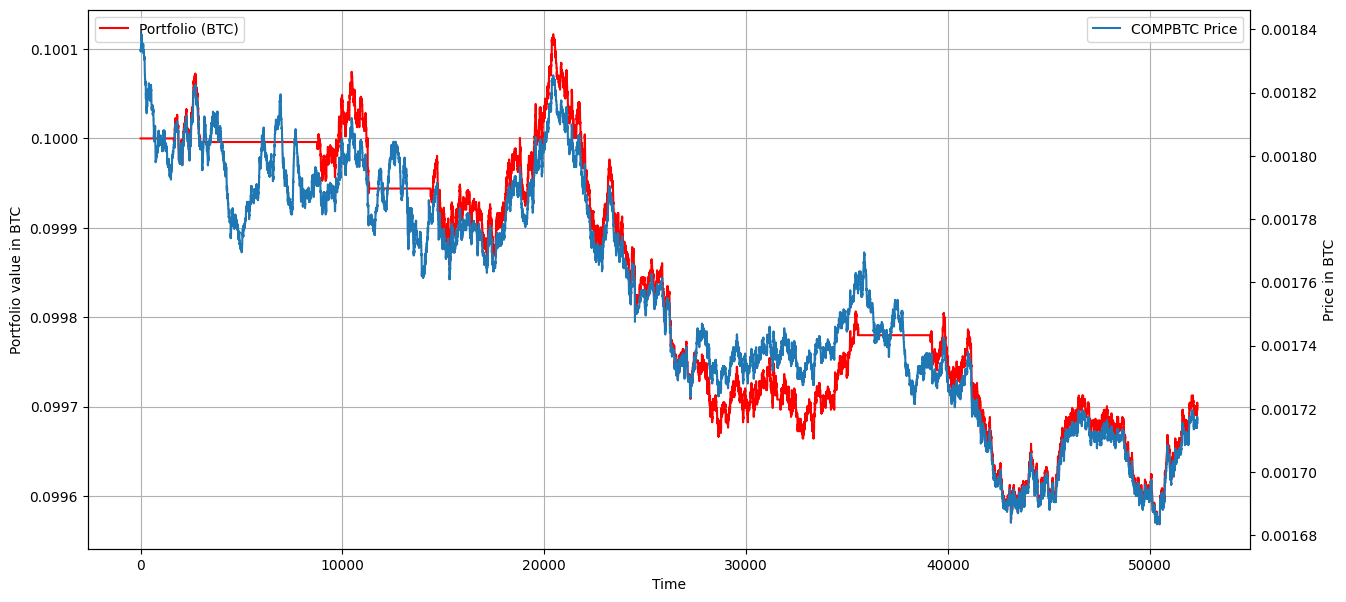

In [17]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')

ax.plot(balances.combined, label='Portfolio (BTC)', color='r')

ax2 = ax.twinx()
ax2.plot(balances.mid, label='COMPBTC Price')
ax.set_xlabel('Time')
ax2.set_ylabel('Price in BTC')
ax.set_ylabel('Portfolio value in BTC')
ax.legend(loc=2)
ax2.legend(loc=1)
ax.grid()